# Topic Modeling with LDA
This notebook compares emails from Katrina Armstrong and Minouche Shafik using Latent Dirichlet Allocation (LDA) to understand thematic differences.

In [16]:
# Standard library
import string
import textwrap

# Data handling
import pandas as pd

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Topic modeling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Statistics
from scipy.stats import ttest_ind

# Visualization
import matplotlib.pyplot as plt


### Download necessary NLTK resources for text preprocessing:

In [17]:
# Check and download necessary NLTK resources
resources = ['stopwords', 'punkt', 'wordnet', 'omw-1.4']
for resource in resources:
    try:
        nltk.data.find(f'corpora/{resource}')
    except LookupError:
        nltk.download(resource)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emmas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\emmas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\emmas\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [18]:
# Load email content
df_katrina = pd.read_excel("Katrina.xlsx")
df_minouche = pd.read_excel("Minouche.xlsx")

# Preview data
#df_katrina.head(), df_minouche.head()

### Cleaning the data

I first tokenize the emails. Tokenization is the process of breaking down a piece of text into smaller units called tokens. These tokens can be words, phrases, or even characters. In this case, the tokens are words. I then convert all words to lowercase, and remove all punctuation. The nltk stopwords module is used to remove words that are common but hold little semantic meaning, like "I, me, yours, theirs, those, has," etc. Finally, I lemmatize the text. Lemmatization is the process of reducing a word to its base or root form, known as the lemma, while ensuring that the resulting word is a valid word in the language. Unlike stemming (which simply trims word endings), lemmatization considers the context and part of speech of the word to produce meaningful root forms. 

#### For example:
Input: ["running", "ran", "runs"]

Lemmatized Output: ["run", "run", "run"]

In [24]:
# Load stopwords
stop_words = set(stopwords.words('english'))

# Load lemmatizer
lemmatizer = WordNetLemmatizer()

# Preprocessing function
def preprocess(texts):
    processed = []
    for doc in texts:
        tokens = word_tokenize(str(doc))                                 # 1. Tokenize
        tokens = [token.lower() for token in tokens]                     # 2. Lowercase
        tokens = [token for token in tokens if token not in string.punctuation]  # 3. Remove punctuation
        tokens = [token for token in tokens if token not in stop_words and len(token) > 2]  # 4. Remove stopwords
        tokens = [lemmatizer.lemmatize(token) for token in tokens]       # 5. Lemmatize
        processed.append(' '.join(tokens))                               # Rejoin for vectorization
    return processed

# Apply preprocessing
katrina_emails = preprocess(df_katrina['Content'].dropna())
minouche_emails = preprocess(df_minouche['Content'].dropna())

print(katrina_emails[:5], minouche_emails[:5])

# Combine and label
corpus = katrina_emails + minouche_emails
labels = ['Katrina'] * len(katrina_emails) + ['Minouche'] * len(minouche_emails)

# Vectorization
vectorizer = CountVectorizer(max_df=0.95, min_df=2)
doc_term_matrix = vectorizer.fit_transform(corpus) 

["shared working year critical priority university find fulfilling commitment website shared progress several key priority u.s. department education u.s. department health human service general service administration find document website past year one enormous progress community thoughtful faculty student stakeholder shaped principled methodical approach meeting moment challenge response government agency outline substantive work 've last academic year advance mission ensure uninterrupted academic activity make every student faculty staff member safe welcome campus much proud community privilege share progress plan spirit great american university expect columbians engage robust debate discussion way forward welcome opportunity shape future columbia way columbia columbians portrayed hard reckon challenge yes define community scholar deep respect mission teach brightest creative student world care deeply every one every faith ability overcome greatest challenge stand resilient brillian

### Fit to LDA model

In [20]:
# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

# Extract top words per topic
words = vectorizer.get_feature_names_out()
topics = []
for idx, topic in enumerate(lda.components_):
    top_words = [words[i] for i in topic.argsort()[:-11:-1]]
    topics.append(top_words)

# Display top words
for i, topic in enumerate(topics):
    print(f"Topic {i+1}: {', '.join(topic)}")

Topic 1: campus, student, faculty, support, group, member, rule, across, safety, work
Topic 2: year, mission, time, academic, institution, student, must, value, commitment, new
Topic 3: student, right, encampment, academic, many, campus, also, everyone, member, time
Topic 4: incident, student, day, campus, member, harassment, respect, right, speech, form
Topic 5: student, many, new, world, protest, academic, also, support, faculty, international


### I asked Chat GPT to summarize each topic:

Topic 1: Community Safety and Conduct

Topic 2: Institutional Mission and Values

Topic 3: Student Activism and Encampments

Topic 4: Harassment, Speech, and Individual Incidents

Topic 5: Protest, International Issues, and Global Context

Label     Katrina  Minouche
Topic 1  0.494328  0.467319
Topic 2  0.426626  0.138025
Topic 3  0.041603  0.103986
Topic 4  0.000978  0.180153
Topic 5  0.036466  0.110517


<Figure size 1000x700 with 0 Axes>

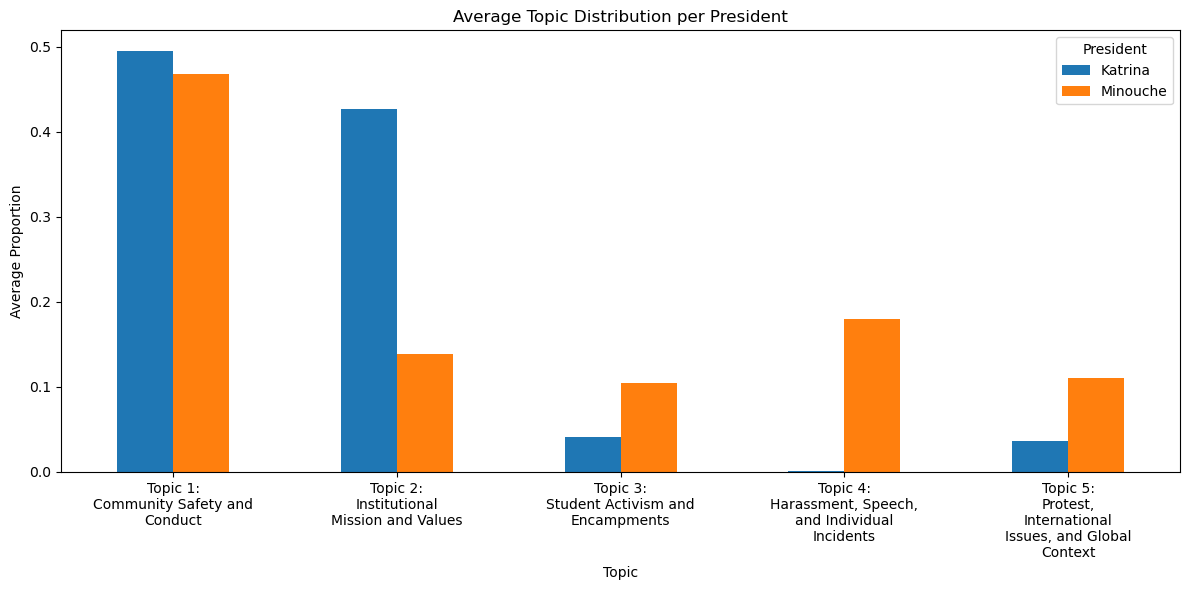

In [26]:
# Assign topics to documents
doc_topics = lda.transform(doc_term_matrix)
df_topics = pd.DataFrame(doc_topics, columns=[f"Topic {i+1}" for i in range(lda.n_components)])
df_topics['Label'] = labels

# Average topic distribution per person
avg_topics = df_topics.groupby("Label").mean().T
print(avg_topics)

# Define descriptive topic labels
phrases = [
    "Community Safety and Conduct",
    "Institutional Mission and Values",
    "Student Activism and Encampments",
    "Harassment, Speech, and Individual Incidents",
    "Protest, International Issues, and Global Context"
]

# Apply labels to index
wrapped_labels = [f"Topic {i+1}:\n" + "\n".join(textwrap.wrap(label, width=20)) for i, label in enumerate(phrases)]

# Display average topic distribution
avg_topics.index = wrapped_labels

# Plot
plt.figure(figsize=(10, 7))
avg_topics.plot(kind='bar', figsize=(12, 6))
plt.title("Average Topic Distribution per President")
plt.ylabel("Average Proportion")
plt.xlabel("Topic")
plt.xticks(rotation=0)
plt.legend(title="President")
plt.tight_layout()
plt.show()

# Significance Test

In [22]:
# Add 'President' column to df_topics
df_topics['President'] = labels

# Identify topic columns (exclude 'President')
topic_cols = [col for col in df_topics.columns if col.startswith("Topic")]

# Split by president
katrina_df = df_topics[df_topics['President'] == 'Katrina']
minouche_df = df_topics[df_topics['President'] == 'Minouche']

# Compute average topic proportions 
avg_topics = df_topics.groupby("President")[topic_cols].mean().T

# Create DataFrame for significance testing
topic_dist_df = df_topics.melt(id_vars='President', var_name='Topic', value_name='Proportion')

# Perform t-test for each topic
results = []
for i, topic in enumerate([f"Topic {i+1}" for i in range(lda.n_components)]):
    katrina_vals = katrina_df[topic]
    minouche_vals = minouche_df[topic]
    t_stat, p_val = ttest_ind(katrina_vals, minouche_vals, equal_var=False)
    results.append({
        'Topic': topic,
        'Category': phrases[i],
        'T-statistic': t_stat,
        'P-value': p_val
    })

# Create DataFrame of t-test results
ttest_df = pd.DataFrame(results)
ttest_df['p < 0.05'] = ttest_df['P-value'] < 0.05

# Reorder columns for clarity
ttest_df = ttest_df[['Topic', 'Category', 'T-statistic', 'P-value', 'p < 0.05']]

# Display results
print("\nStatistical Significance of Topic Differences Between Presidents:\n")
print(ttest_df.to_string(index=False))

# Save to file
ttest_df.to_csv("topic_significance_results.csv", index=False)
# ttest_df.to_excel("topic_significance_results.xlsx", index=False)



Statistical Significance of Topic Differences Between Presidents:

  Topic                                          Category  T-statistic  P-value  p < 0.05
Topic 1                      Community Safety and Conduct     0.200422 0.842369     False
Topic 2                  Institutional Mission and Values     2.720051 0.009464      True
Topic 3                  Student Activism and Encampments    -0.848640 0.404248     False
Topic 4      Harassment, Speech, and Individual Incidents    -1.936417 0.070684     False
Topic 5 Protest, International Issues, and Global Context    -0.996443 0.328385     False


# Word Occurence

In [23]:
# Function to count occurrences of specific words
def count_words(df, column, words):
    count = 0
    for text in df[column].dropna():
        text = str(text).lower()
        for word in words:
            count += text.split().count(word)
    return count

# Words to search for
principle = ["principle", "principles", "principled", "value", "values"]
conversation = ["conversation", "conversations", "discuss", "discussed", "discussion", "dialogue"]
freedom = ["free", "freedom"]

# Count occurrences for princple
katrina_principle = count_words(df_katrina, "Content", principle)
minouche_principle = count_words(df_minouche, "Content", principle)

# Count occurences for conversation
katrina_convo = count_words(df_katrina, "Content", conversation)
minouche_convo = count_words(df_minouche, "Content", conversation)

# Count occurences for freedom
free_katrina = count_words(df_katrina, "Content", freedom)
free_minouche = count_words(df_minouche, "Content", freedom)

# Display results
print("PRINCIPLE")
print(f"Occurrences in Katrina's emails: {katrina_principle}")
print(f"Occurrences in Minouche's emails: {minouche_principle}")


print("CONVERSATION")
print(f"Occurrences in Katrina's emails: {katrina_convo}")
print(f"Occurrences in Minouche's emails: {minouche_convo}")

print("FREEDOM")
print(f"Occurrences in Katrina's emails: {free_katrina}")
print(f"Occurrences in Minouche's emails: {free_minouche}")

PRINCIPLE
Occurrences in Katrina's emails: 48
Occurrences in Minouche's emails: 25
CONVERSATION
Occurrences in Katrina's emails: 26
Occurrences in Minouche's emails: 20
FREEDOM
Occurrences in Katrina's emails: 39
Occurrences in Minouche's emails: 19
